In [4]:
from __future__ import print_function

import os
import sys
sys.path.append('/home/jogi/git/repository/smart_play_set')

import matplotlib.pyplot as plt
from matplotlib import rc

import numpy as np
import scipy.stats as stats
from scipy import interp
from itertools import cycle

from utils.smart_utils import get_dir_path, tensor_to_pandas, load_hdf5_file
from utils.smart_utils import get_array_filenames, split_on_classes, create_row_mask
from utils.smart_utils import FuturoCube, calc_cos_sim, get_other_label
from preprocessing.process_data import get_data

from sklearn.svm import LinearSVC, SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.feature_selection import RFECV
from sklearn.metrics import roc_curve, auc
from skfeature.function.similarity_based import reliefF

from sklearn.metrics import confusion_matrix
import itertools

from sklearn.manifold import TSNE
from collections import OrderedDict

%matplotlib inline
%load_ext autoreload
%autoreload 2

PLOT_OUTPUT_DIR = '/home/jogi/git/repository/smart_play_set/plots/'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
"""
    (1) Two-Sample T-Test: stats.ttest_ind
    (2) Paired T-Test (difference within the same group at different times)
                    stats.ttest_rel(a = before, b = after)
"""
def compute_t_test(X, y, feature_idxs, features, class_labels=[0,1]):
    
    # assuming binary classes
    normal = y == class_labels[0]
    positive = y == class_labels[1]
    print("")
    print("==================== Two sample T-test between classes for features selected ==================")
    print("Normal/Positive ", np.count_nonzero(normal), np.count_nonzero(positive))
    
    for f in feature_idxs:
        n_group = X[normal, f]
        p_group = X[positive, f]

        t_value, p_value = stats.ttest_ind(a=n_group, b=p_group, equal_var=False)    
        # print("Feature %s: t_value %.4f, p_value %.4f, mean-normal %.3f, mean-positive %.3f" % 
        #     (features[f], t_value, p_value, np.mean(n_group), np.mean(p_group)))
        print("Feature %s: p_value %.4f" % (features[f], p_value))

# y_labels = y_labels_2c[:]
# compute_t_test(x_train_all, y_labels, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], features)

In [9]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

def create_level_sets(X, skill_labels, level_labels):
    
    unique_levels = np.unique(level_labels)
    print("INFO -- create_level_sets ", unique_levels)
    datasets = {}
    for l in unique_levels:
        rows = np.where(level_labels==l)[0]
        x_data = X[rows]
        y_data = skill_labels[rows]
        datasets[l] = (x_data, y_data)
    
    return datasets
    
def get_features(mask, features):

    for i, f in enumerate(mask):
        print("%d. %s" % (i+1, features[f]))

        
def transform_x(X, features_idx):
    
    X_new = np.zeros((X.shape[0], len(features_idx)))
    for i, idx in enumerate(features_idx):
        X_new[:, i] = X[:, idx]
        
    return X_new


def prepare_data(option=330, two_class_opt='2_and_1'):
    
    if option == 330:
        x_train_all, y_labels_all, y_other_labels, dta_dict_f = get_data('20161206', force=False, 
                                                               apply_window_func=True, calc_mag=True,
                                                               extra_label="20hz_1axis_low8hz_330_12_True", 
                                                               optimal_w_size=False,
                                                               f_type='low', lowcut=8, b_order=5)
    elif option == 180:
        x_train_all, y_labels_all, y_other_labels, dta_dict_f = get_data('20161206', force=False, 
                                                               apply_window_func=True, calc_mag=True,
                                                               extra_label="20hz_1axis_low8hz_180_12_True", 
                                                               optimal_w_size=False,
                                                               f_type='low', lowcut=8, b_order=5)

    elif option == 990:
        x_train_all, y_labels_all, y_other_labels, dta_dict_f = get_data('20161206', force=False, 
                                                               apply_window_func=True, calc_mag=True,
                                                               extra_label="20hz_1axis_low8hz_990_12_True", 
                                                               optimal_w_size=False,
                                                               f_type='low', lowcut=8, b_order=5)
    elif option == 3960:  # 5 seconds with 0.5 overlapping
        
        x_train_all, y_labels_all, y_other_labels, dta_dict_f = get_data('20161206', force=False, 
                                                               apply_window_func=True, calc_mag=True,
                                                               extra_label="20hz_1axis_low8hz_3960_12_True", 
                                                               optimal_w_size=False,
                                                               f_type='low', lowcut=8, b_order=5)
    else:
        raise NotImplementedError("Error, %s as option is not implemented" % str(option))

    features = dta_dict_f['features']

    y_labels_all = np.squeeze(y_labels_all)
    y_labels_2c = np.zeros(y_labels_all.shape[0], dtype=np.int)
    y_labels_2c[:] = y_labels_all[:]
    if two_class_opt == 'merge_1_2':
        # merge group 1 and 2
        y_labels_2c[y_labels_2c==2] = 1
        print(np.where(y_labels_2c==0)[0].shape)
        print(np.where(y_labels_2c==1)[0].shape)
    elif two_class_opt == 'merge_0_1':
        # merge 1 with 0 group
        y_labels_2c[y_labels_2c==1] = 0
        y_labels_2c[y_labels_2c==2] = 1
        print(np.where(y_labels_2c==0)[0].shape)
        print(np.where(y_labels_2c==1)[0].shape)
    elif two_class_opt == 'only_0_2':
        x_train_all = x_train_all[np.where((y_labels_all==0) | (y_labels_all==2))]
        y_labels_all = y_labels_all[np.where((y_labels_all==0) | (y_labels_all==2))]
        y_other_labels = y_other_labels[np.where((y_labels_all==0) | (y_labels_all==2))]
        y_labels_all[y_labels_all==2] = 1
        y_labels_2c = y_labels_all
    elif two_class_opt == 'only_0_1':
        x_train_all = x_train_all[np.where((y_labels_all==0) | (y_labels_all==1))]
        y_labels_all = y_labels_all[np.where((y_labels_all==0) | (y_labels_all==1))]
        y_other_labels = y_other_labels[np.where((y_labels_all==0) | (y_labels_all==1))]
        y_labels_2c = y_labels_all
        
    print("Unique labels y_labels_all ", np.unique(y_labels_all))
    print("Unique labels y_labels_2c ", np.unique(y_labels_2c))
    print("Class counts y_labels_all ", np.bincount(y_labels_all))
    print("Class counts y_labels_2c ", np.bincount(y_labels_2c))
    print("Shape x_train_all ", x_train_all.shape)
    print("Shape y_labels_all ", y_labels_all.shape)
    
    return x_train_all, y_labels_all, y_labels_2c, y_other_labels, features

x_train_all, y_labels_all, y_labels_2c, y_other_labels, features = prepare_data(330, two_class_opt='merge_1_2')
level_datasets = create_level_sets(x_train_all, y_labels_2c, get_other_label(y_other_labels, 'level'))
for key, data in level_datasets.iteritems():
    print(key, data[0].shape, data[1].shape)
y_label_id = get_other_label(y_other_labels, "ID")
y_label_perm = get_other_label(y_other_labels, "perm")
y_label_level = get_other_label(y_other_labels, "level")
print(features)

INFO - Used data label 20161206_futurocube_roadrunner_20hz_1axis_low8hz_330_12_True
INFO Loading matrices from h5 file /mnt/disk2/git/repository/smart_play_set/data/futurocube/roadrunner/20161206_futurocube_roadrunner_20hz_1axis_low8hz_330_12_True.h5
('INFO - List of arrays in this file: \n', [u'feature_data', u'label_data', u'label_game_level'])
INFO - Loading data description from json.
(210,)
(120,)
Unique labels y_labels_all  [0 1 2]
Unique labels y_labels_2c  [0 1]
Class counts y_labels_all  [210  60  60]
Class counts y_labels_2c  [210 120]
Shape x_train_all  (330, 12)
Shape y_labels_all  (330,)
INFO -- create_level_sets  [1 2 3]
1 (110, 12) (110,)
2 (110, 12) (110,)
3 (110, 12) (110,)
[u'minf', u'rms', u'mean_squared_jerk', u'dc', u'energy', u'power_spec_entropy', u'cos_sim', u'maxf', u'mean', u'std', u'median', u'range']


## (1) Accuracy/F1 scores & confusion matrix for 8 features with 2 classifiers

##### gnb = Gaussian Naive Bayes
##### svc = SVM with radial basis function kernel

#### Features
    mean_squared_jerk
    std
    median
    cos_sim
    mean
    rms
    energy
    minf

#### Results are reported for 
    complete dataset
    per game level (1,2 and 3)
    
    

In [7]:
gnb = GaussianNB()
svc = SVC(kernel="rbf", C=1.)
linearSVC = LinearSVC(C=1., penalty="l2", dual=False, loss='squared_hinge')


==================== Two sample T-test between classes for features selected ==================
Normal/Positive  210 120
Feature mean_squared_jerk: p_value 0.0000
Feature std: p_value 0.1916
Feature median: p_value 0.0000
Feature cos_sim: p_value 0.0000
Feature mean: p_value 0.0533
Feature rms: p_value 0.0142
Feature energy: p_value 0.0576
Feature minf: p_value 0.0408
--- Final score with k-fold cross-validation
svc(8) - Accuracy: 0.727 (+/- 0.28)
svc(8) - F1: 0.706 (+/- 0.31)
svc(8) - Precision: 0.721 (+/- 0.33)
svc(8) - Recall: 0.727 (+/- 0.28)
gnb(8) - Accuracy: 0.742 (+/- 0.26)
gnb(8) - F1: 0.732 (+/- 0.27)
gnb(8) - Precision: 0.746 (+/- 0.29)
gnb(8) - Recall: 0.742 (+/- 0.26)
Confusion matrix, without normalization


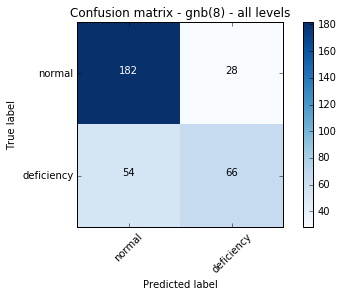

--- Evaluation of classifier per level-dataset
shape of new_x (110, 8) (110,)
Evaluation for level (1)
gnb(8) - Accuracy: 0.682 (+/- 0.28)
gnb(8) - F1: 0.648 (+/- 0.33)
gnb(8) - Precision: 0.647 (+/- 0.41)
gnb(8) - Recall: 0.682 (+/- 0.28)
Confusion matrix, without normalization


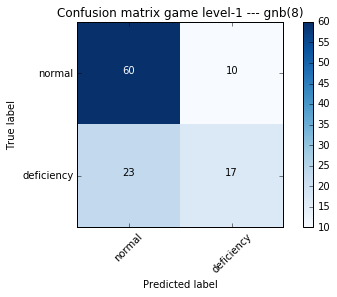

shape of new_x (110, 8) (110,)
Evaluation for level (2)
gnb(8) - Accuracy: 0.764 (+/- 0.20)
gnb(8) - F1: 0.751 (+/- 0.21)
gnb(8) - Precision: 0.782 (+/- 0.23)
gnb(8) - Recall: 0.764 (+/- 0.20)
Confusion matrix, without normalization


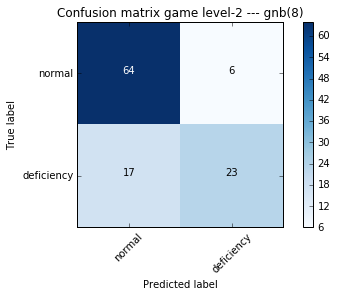

shape of new_x (110, 8) (110,)
Evaluation for level (3)
gnb(8) - Accuracy: 0.691 (+/- 0.37)
gnb(8) - F1: 0.691 (+/- 0.37)
gnb(8) - Precision: 0.716 (+/- 0.37)
gnb(8) - Recall: 0.691 (+/- 0.37)
Confusion matrix, without normalization


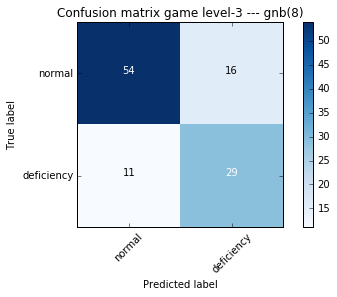

In [13]:
#     0       1             2              3         4              5
# [u'minf', u'rms', u'mean_squared_jerk', u'dc', u'energy', u'power_spec_entropy', 
#                                                      6          7       8        9        10         11
#                                                  u'cos_sim', u'maxf', u'mean', u'std', u'median', u'range']

y_labels = y_labels_2c[:]
# y_labels = y_labels_all

# feature_list = [2,5,6]
feature_list = [2, 9, 10, 6, 8, 1, 4, 0]   # feature list from ReliefF algo with 2 classes
# [u'mean_squared_jerk', u'std', u'median', u'cos_sim', u'mean', u'rms', u'energy', u'minf']
new_X_all = transform_x(x_train_all, feature_list)

compute_t_test(x_train_all, y_labels, feature_list, features)

print("--- Final score with k-fold cross-validation")

scores_svc_acc = cross_val_score(OneVsRestClassifier(linearSVC), new_X_all, y_labels, cv=StratifiedKFold(10),
                             scoring='accuracy')
scores_svc_f1 = cross_val_score(OneVsRestClassifier(linearSVC), new_X_all, y_labels, cv=StratifiedKFold(10),
                             scoring='f1_weighted')
scores_svc = cross_val_score(OneVsRestClassifier(linearSVC), new_X_all, y_labels, cv=StratifiedKFold(10), 
                             scoring='accuracy')
print("svc(%d) - Accuracy: %0.3f (+/- %0.2f)" % (new_X_all.shape[1], scores_svc.mean(), scores_svc.std() * 2))
scores_svc = cross_val_score(OneVsRestClassifier(linearSVC), new_X_all, y_labels, cv=StratifiedKFold(10), 
                             scoring='f1_weighted')
print("svc(%d) - F1: %0.3f (+/- %0.2f)" % (new_X_all.shape[1], scores_svc.mean(), scores_svc.std() * 2))
scores_svc = cross_val_score(OneVsRestClassifier(linearSVC), new_X_all, y_labels, cv=StratifiedKFold(10), 
                             scoring='precision_weighted')
print("svc(%d) - Precision: %0.3f (+/- %0.2f)" % (new_X_all.shape[1], scores_svc.mean(), scores_svc.std() * 2))
scores_svc = cross_val_score(OneVsRestClassifier(linearSVC), new_X_all, y_labels, cv=StratifiedKFold(10), 
                             scoring='recall_weighted')
print("svc(%d) - Recall: %0.3f (+/- %0.2f)" % (new_X_all.shape[1], scores_svc.mean(), scores_svc.std() * 2))



scores_gnb = cross_val_score(gnb, new_X_all, y_labels, cv=StratifiedKFold(10), scoring='accuracy')
print("gnb(%d) - Accuracy: %0.3f (+/- %0.2f)" % (new_X_all.shape[1], scores_gnb.mean(), scores_gnb.std() * 2))
scores_gnb = cross_val_score(gnb, new_X_all, y_labels, cv=StratifiedKFold(10), scoring='f1_weighted')
print("gnb(%d) - F1: %0.3f (+/- %0.2f)" % (new_X_all.shape[1], scores_gnb.mean(), scores_gnb.std() * 2))
scores_gnb = cross_val_score(gnb, new_X_all, y_labels, cv=StratifiedKFold(10), scoring='precision_weighted')
print("gnb(%d) - Precision: %0.3f (+/- %0.2f)" % (new_X_all.shape[1], scores_gnb.mean(), scores_gnb.std() * 2))
scores_gnb = cross_val_score(gnb, new_X_all, y_labels, cv=StratifiedKFold(10), scoring='recall_weighted')
print("gnb(%d) - Recall: %0.3f (+/- %0.2f)" % (new_X_all.shape[1], scores_gnb.mean(), scores_gnb.std() * 2))

gnb.fit(new_X_all, y_labels)
y_pred = gnb.predict(new_X_all)
c_matrix = confusion_matrix(y_labels, y_pred)
plt.figure()
plot_title = "Confusion matrix - gnb(%d) - all levels" % new_X_all.shape[1]
plot_confusion_matrix(c_matrix, classes=["normal", "deficiency"], title=plot_title)
plt.show()

print("===================================================================")
print("--- Evaluation of classifier per level-dataset")
for key, data in level_datasets.iteritems():
    x_data = data[0]
    y_data = data[1]
    new_X = transform_x(x_data, feature_list)
    print("shape of new_x", new_X.shape, y_data.shape)
    print("Evaluation for level (%d)" % key)
    scores_gnb = cross_val_score(gnb, new_X, y_data, cv=StratifiedKFold(10), scoring='accuracy')
    print("gnb(%d) - Accuracy: %0.3f (+/- %0.2f)" % (new_X.shape[1], scores_gnb.mean(), scores_gnb.std() * 2))
    scores_gnb = cross_val_score(gnb, new_X, y_data, cv=StratifiedKFold(10), scoring='f1_weighted')
    print("gnb(%d) - F1: %0.3f (+/- %0.2f)" % (new_X.shape[1], scores_gnb.mean(), scores_gnb.std() * 2))
    scores_gnb = cross_val_score(gnb, new_X, y_data, cv=StratifiedKFold(10), scoring='precision_weighted')
    print("gnb(%d) - Precision: %0.3f (+/- %0.2f)" % (new_X.shape[1], scores_gnb.mean(), scores_gnb.std() * 2))
    scores_gnb = cross_val_score(gnb, new_X, y_data, cv=StratifiedKFold(10), scoring='recall_weighted')
    print("gnb(%d) - Recall: %0.3f (+/- %0.2f)" % (new_X.shape[1], scores_gnb.mean(), scores_gnb.std() * 2))
    
    gnb.fit(new_X, y_data)
    y_pred = gnb.predict(new_X)
    c_matrix = confusion_matrix(y_data, y_pred)
    plt.figure()
    plot_title = "Confusion matrix game level-%d --- gnb(%d)" % (key, new_X.shape[1])
    plot_confusion_matrix(c_matrix, classes=["normal", "deficiency"], title=plot_title)
    plt.show()
    



## (2) Accuracy/F1 scores & confusion matrix for 3 features with 2 classifiers

##### gnb = Gaussian Naive Bayes
##### svc = SVM with radial basis function kernel

#### Features
    mean_squared_jerk
    power_spec_entropy
    cos_sim

#### Results are reported for 
    complete dataset
    per game level (1,2 and 3)
    



==================== Two sample T-test between classes for features selected ==================
Normal/Positive  210 120
Feature mean_squared_jerk: p_value 0.0000
Feature power_spec_entropy: p_value 0.0001
Feature cos_sim: p_value 0.0000
--- Final score with k-fold cross-validation
svc(3) - Accuracy: 0.736 (+/- 0.31)
svc(3) - F1: 0.714 (+/- 0.34)
svc(3) - Precision: 0.735 (+/- 0.36)
svc(3) - Recall: 0.736 (+/- 0.31)
gnb(3) - Accuracy: 0.745 (+/- 0.25)
gnb(3) - F1: 0.726 (+/- 0.27)
gnb(3) - Precision: 0.744 (+/- 0.29)
gnb(3) - Recall: 0.745 (+/- 0.25)
Confusion matrix, without normalization


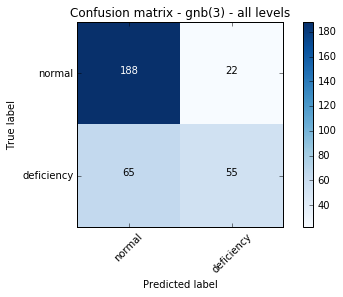

--- Evaluation of classifier per level-dataset
shape of new_x (110, 3) (110,)
Evaluation for level (1)
gnb(3) - Accuracy: 0.718 (+/- 0.29)
gnb(3) - F1: 0.674 (+/- 0.36)
gnb(3) - Precision: 0.678 (+/- 0.44)
gnb(3) - Recall: 0.718 (+/- 0.29)
Confusion matrix, without normalization


/home/jogi/.local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/jogi/.local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


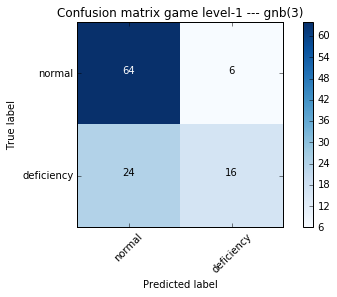

shape of new_x (110, 3) (110,)
Evaluation for level (2)
gnb(3) - Accuracy: 0.782 (+/- 0.19)
gnb(3) - F1: 0.764 (+/- 0.20)
gnb(3) - Precision: 0.793 (+/- 0.23)
gnb(3) - Recall: 0.782 (+/- 0.19)
Confusion matrix, without normalization


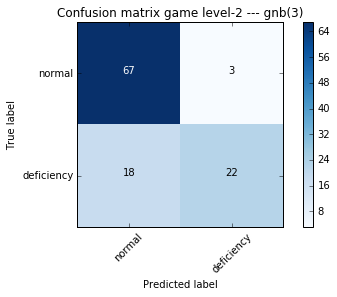

shape of new_x (110, 3) (110,)
Evaluation for level (3)
gnb(3) - Accuracy: 0.736 (+/- 0.42)
gnb(3) - F1: 0.731 (+/- 0.42)
gnb(3) - Precision: 0.746 (+/- 0.43)
gnb(3) - Recall: 0.736 (+/- 0.42)
Confusion matrix, without normalization


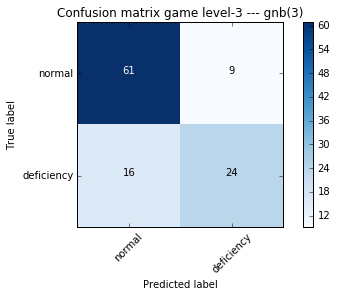

In [12]:
#     0       1             2              3         4              5
# [u'minf', u'rms', u'mean_squared_jerk', u'dc', u'energy', u'power_spec_entropy', 
#                                                      6          7       8        9        10         11
#                                                  u'cos_sim', u'maxf', u'mean', u'std', u'median', u'range']

y_labels = y_labels_2c[:]
# y_labels = y_labels_all

feature_list = [2,5,6]
# feature_list = [2, 9, 10, 6, 8, 1, 4, 0]   # feature list from ReliefF algo with 2 classes
# [u'mean_squared_jerk', u'std', u'median', u'cos_sim', u'mean', u'rms', u'energy', u'minf']
new_X_all = transform_x(x_train_all, feature_list)

compute_t_test(x_train_all, y_labels, feature_list, features)

print("--- Final score with k-fold cross-validation")

scores_svc_acc = cross_val_score(OneVsRestClassifier(linearSVC), new_X_all, y_labels, cv=StratifiedKFold(10),
                             scoring='accuracy')
scores_svc_f1 = cross_val_score(OneVsRestClassifier(linearSVC), new_X_all, y_labels, cv=StratifiedKFold(10),
                             scoring='f1_weighted')
scores_svc = cross_val_score(OneVsRestClassifier(linearSVC), new_X_all, y_labels, cv=StratifiedKFold(10), 
                             scoring='accuracy')
print("svc(%d) - Accuracy: %0.3f (+/- %0.2f)" % (new_X_all.shape[1], scores_svc.mean(), scores_svc.std() * 2))
scores_svc = cross_val_score(OneVsRestClassifier(linearSVC), new_X_all, y_labels, cv=StratifiedKFold(10), 
                             scoring='f1_weighted')
print("svc(%d) - F1: %0.3f (+/- %0.2f)" % (new_X_all.shape[1], scores_svc.mean(), scores_svc.std() * 2))
scores_svc = cross_val_score(OneVsRestClassifier(linearSVC), new_X_all, y_labels, cv=StratifiedKFold(10), 
                             scoring='precision_weighted')
print("svc(%d) - Precision: %0.3f (+/- %0.2f)" % (new_X_all.shape[1], scores_svc.mean(), scores_svc.std() * 2))
scores_svc = cross_val_score(OneVsRestClassifier(linearSVC), new_X_all, y_labels, cv=StratifiedKFold(10), 
                             scoring='recall_weighted')
print("svc(%d) - Recall: %0.3f (+/- %0.2f)" % (new_X_all.shape[1], scores_svc.mean(), scores_svc.std() * 2))



scores_gnb = cross_val_score(gnb, new_X_all, y_labels, cv=StratifiedKFold(10), scoring='accuracy')
print("gnb(%d) - Accuracy: %0.3f (+/- %0.2f)" % (new_X_all.shape[1], scores_gnb.mean(), scores_gnb.std() * 2))
scores_gnb = cross_val_score(gnb, new_X_all, y_labels, cv=StratifiedKFold(10), scoring='f1_weighted')
print("gnb(%d) - F1: %0.3f (+/- %0.2f)" % (new_X_all.shape[1], scores_gnb.mean(), scores_gnb.std() * 2))
scores_gnb = cross_val_score(gnb, new_X_all, y_labels, cv=StratifiedKFold(10), scoring='precision_weighted')
print("gnb(%d) - Precision: %0.3f (+/- %0.2f)" % (new_X_all.shape[1], scores_gnb.mean(), scores_gnb.std() * 2))
scores_gnb = cross_val_score(gnb, new_X_all, y_labels, cv=StratifiedKFold(10), scoring='recall_weighted')
print("gnb(%d) - Recall: %0.3f (+/- %0.2f)" % (new_X_all.shape[1], scores_gnb.mean(), scores_gnb.std() * 2))

gnb.fit(new_X_all, y_labels)
y_pred = gnb.predict(new_X_all)
c_matrix = confusion_matrix(y_labels, y_pred)
plt.figure()
plot_title = "Confusion matrix - gnb(%d) - all levels" % new_X_all.shape[1]
plot_confusion_matrix(c_matrix, classes=["normal", "deficiency"], title=plot_title)
plt.show()

print("===================================================================")
print("--- Evaluation of classifier per level-dataset")
for key, data in level_datasets.iteritems():
    x_data = data[0]
    y_data = data[1]
    new_X = transform_x(x_data, feature_list)
    print("shape of new_x", new_X.shape, y_data.shape)
    print("Evaluation for level (%d)" % key)
    scores_gnb = cross_val_score(gnb, new_X, y_data, cv=StratifiedKFold(10), scoring='accuracy')
    print("gnb(%d) - Accuracy: %0.3f (+/- %0.2f)" % (new_X.shape[1], scores_gnb.mean(), scores_gnb.std() * 2))
    scores_gnb = cross_val_score(gnb, new_X, y_data, cv=StratifiedKFold(10), scoring='f1_weighted')
    print("gnb(%d) - F1: %0.3f (+/- %0.2f)" % (new_X.shape[1], scores_gnb.mean(), scores_gnb.std() * 2))
    scores_gnb = cross_val_score(gnb, new_X, y_data, cv=StratifiedKFold(10), scoring='precision_weighted')
    print("gnb(%d) - Precision: %0.3f (+/- %0.2f)" % (new_X.shape[1], scores_gnb.mean(), scores_gnb.std() * 2))
    scores_gnb = cross_val_score(gnb, new_X, y_data, cv=StratifiedKFold(10), scoring='recall_weighted')
    print("gnb(%d) - Recall: %0.3f (+/- %0.2f)" % (new_X.shape[1], scores_gnb.mean(), scores_gnb.std() * 2))
    
    gnb.fit(new_X, y_data)
    y_pred = gnb.predict(new_X)
    c_matrix = confusion_matrix(y_data, y_pred)
    plt.figure()
    plot_title = "Confusion matrix game level-%d --- gnb(%d)" % (key, new_X.shape[1])
    plot_confusion_matrix(c_matrix, classes=["normal", "deficiency"], title=plot_title)
    plt.show()
    



## (3) Feature selection with ReliefF algorithm

    Ranking of features according to evaluation score of algorithm
    Remove feature with the lowest score in each iteration step until we're left with 1 feature
    Test feature set each time with Naive Bayes & SVM by means of cross-fold validation (reporting accuracy and F1 score)
    

======= 12 feature-ranking =======
gnb(12) - Accuracy: 0.733 (+/- 0.265)
gnb(12) - f1: 0.725 (+/- 0.274)
gnb(12) - recall: 0.733 (+/- 0.265)
svc(12) - Accuracy: 0.718 (+/- 0.217)
svc(12) - f1: 0.683 (+/- 0.264)
svc(12) - recall: 0.718 (+/- 0.217)
Ranked features  [u'mean_squared_jerk', u'median', u'std', u'cos_sim', u'minf', u'range', u'rms', u'power_spec_entropy', u'mean', u'energy', u'maxf', u'dc']
Ranked features idx  [2, 10, 9, 6, 0, 11, 1, 5, 8, 4, 7, 3]

==================== Two sample T-test between classes for features selected ==================
Normal/Positive  210 120
Feature mean_squared_jerk: p_value 0.0000
Feature median: p_value 0.0000
Feature std: p_value 0.1916
Feature cos_sim: p_value 0.0000
Feature minf: p_value 0.0408
Feature range: p_value 0.1051
Feature rms: p_value 0.0142
Feature power_spec_entropy: p_value 0.0001
Feature mean: p_value 0.0533
Feature energy: p_value 0.0576
Feature maxf: p_value 0.2346
Feature dc: p_value 0.2346
New shape train_data  (330, 11)
===

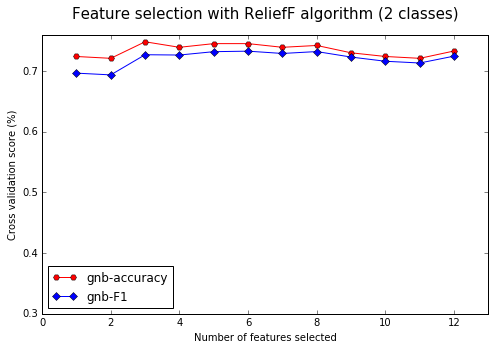

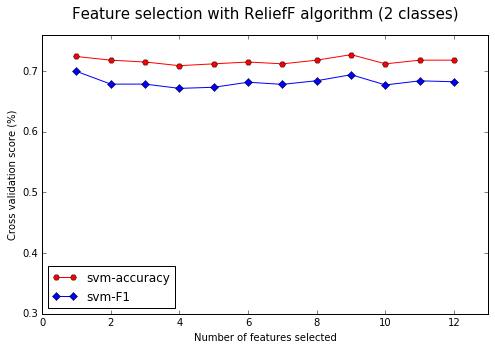

In [14]:
y_labels = y_labels_2c[:]
# y_labels = y_labels_all
# best with 3 classes, 6 features [u'mean_squared_jerk', u'range', u'mean', u'std', u'minf', u'rms']
"""
best with 2 classes:
====================
(1) 8 features
gnb(8) - Accuracy: 0.742 (+/- 0.265)
gnb(8) - f1: 0.602 (+/- 0.412)
svc(8) - Accuracy: 0.718 (+/- 0.197)
svc(8) - f1: 0.471 (+/- 0.401)

mean_squared_jerk 44.2379689568
std 22.2526246915
median 18.7887949492
cos_sim 17.3191976537
mean 15.3754210695
energy 14.7320186932
rms 14.470910009
minf 12.3461975466

or 
(2) 6 features
gnb(6) - Accuracy: 0.745 (+/- 0.243)
gnb(6) - f1: 0.595 (+/- 0.402)
svc(6) - Accuracy: 0.715 (+/- 0.201)
svc(6) - f1: 0.469 (+/- 0.394)

mean_squared_jerk 45.208456643
std 28.1811006354
mean 16.9884122425
median 14.3950405564
cos_sim 12.7935735104
rms 10.8215152881
"""

kept_feature_dict = {}
res_gnb_acc = []
res_gnb_f1 = []
res_gnb_rc = []
res_svc_acc = []
res_svc_f1 = []
res_svc_rc = []

feature_list = [f for f in features]
train_data = np.zeros_like(x_train_all)
train_data[:] = x_train_all[:]
# train_data = level_datasets[1][0]
# y_labels = level_datasets[1][1]

gnb = GaussianNB()
svc = SVC(kernel="rbf", C=1.)
linearSVC = LinearSVC(C=1., penalty="l2", dual=False, loss='squared_hinge')
num_of_times = 25
k = 10
num_of_classes = len(np.unique(y_labels))
num_of_samples = train_data.shape[0]
class_labels = "".join([str(int(i)) for i in np.unique(y_labels)])
feature_list_length = []
    
for f_num in np.arange(len(features)):
    print("======= %d feature-ranking =======" % len(feature_list))
    feature_list_length.append(len(feature_list))
    scores_acc_gnb = cross_val_score(gnb, train_data, y_labels, cv=StratifiedKFold(10), scoring='accuracy')
    scores_acc_svc = cross_val_score(svc, train_data, y_labels, cv=StratifiedKFold(10), scoring='accuracy')
    
    scores_f1_gnb = cross_val_score(gnb, train_data, y_labels, cv=StratifiedKFold(10), scoring='f1_weighted')
    scores_rc_gnb = cross_val_score(gnb, train_data, y_labels, cv=StratifiedKFold(10), scoring='recall_weighted')
    scores_f1_svc = cross_val_score(svc, train_data, y_labels, cv=StratifiedKFold(10), scoring='f1_weighted')
    scores_rc_svc = cross_val_score(svc, train_data, y_labels, cv=StratifiedKFold(10), scoring='recall_weighted')
    
    
    print("gnb(%d) - Accuracy: %0.3f (+/- %0.3f)" % (train_data.shape[1], scores_acc_gnb.mean(), 
                                                     scores_acc_gnb.std() * 2))

    print("gnb(%d) - f1: %0.3f (+/- %0.3f)" % (train_data.shape[1], scores_f1_gnb.mean(), 
                                               scores_f1_gnb.std() * 2))
    print("gnb(%d) - recall: %0.3f (+/- %0.3f)" % (train_data.shape[1], scores_rc_gnb.mean(), 
                                               scores_rc_gnb.std() * 2))
    res_gnb_f1.append(scores_f1_gnb.mean())
    res_gnb_rc.append(scores_rc_gnb.mean())
        
    res_gnb_acc.append(scores_acc_gnb.mean())
        
    print("svc(%d) - Accuracy: %0.3f (+/- %0.3f)" % (train_data.shape[1], scores_acc_svc.mean(), 
                                                     scores_acc_svc.std() * 2))

    print("svc(%d) - f1: %0.3f (+/- %0.3f)" % (train_data.shape[1], scores_f1_svc.mean(), 
                                               scores_f1_svc.std() * 2))
    print("svc(%d) - recall: %0.3f (+/- %0.3f)" % (train_data.shape[1], scores_rc_svc.mean(), 
                                               scores_rc_svc.std() * 2))
    res_svc_f1.append(scores_f1_svc.mean())
    res_svc_rc.append(scores_rc_svc.mean())
        
    res_svc_acc.append(scores_acc_svc.mean())
    final_score = np.zeros(len(feature_list))

    for i in np.arange(num_of_times):
        new_relief_score = reliefF.reliefF(train_data, y_labels, **{"k": k})
        final_score += new_relief_score

    final_score /= num_of_times
    
    new_feature_list = []
    new_feature_idx = []
    for i, idx in enumerate(np.argsort(final_score)[::-1]):
        # print(feature_list[idx], final_score[idx])
        new_feature_list.append(feature_list[idx])
        new_feature_idx.append(idx)
    
    print("Ranked features ", new_feature_list)
    print("Ranked features idx ", new_feature_idx)
    kept_feature_dict[len(new_feature_list)] = new_feature_list
    compute_t_test(train_data, y_labels, new_feature_idx, feature_list)
    
    feature_list = new_feature_list[:-1]
    new_feature_idx = new_feature_idx[:-1]
    train_data = transform_x(train_data, new_feature_idx)
    print("New shape train_data ", train_data.shape)
    
    
# Plot number of features VS. cross-validation scores
markers = ['D', 'H'] # x', '+', '^', 'D', '<', '>', '8', '*', 'H', 'o']
colors = ['b', 'r', 'y']
plt.figure(figsize=(8, 5))
plt.xlim([0, len(features)+1])
plt.ylim([0.30,0.76])
plt.title("Feature selection with ReliefF algorithm (%d classes)" % len(np.unique(y_labels)), fontsize=15, y=1.04)
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (%)")
plt.plot(feature_list_length, res_gnb_acc, 'Hr-', label="gnb-accuracy")

plt.plot(feature_list_length, res_gnb_f1, 'Db-', label="gnb-F1")
# plt.plot(feature_list_length, res_gnb_rc, 'xg-', label="gnb-recall")
plt.legend(loc="best")
outfile = PLOT_OUTPUT_DIR + 'gnb_feature_sel_reliefF_' + str(num_of_samples) + "_" + str(num_of_classes) + \
                                "_" + class_labels + 'classes.png'

print("Save to %s" % outfile)
plt.savefig(outfile, dpi=100)

plt.figure(figsize=(8, 5))
plt.xlim([0, len(features)+1])
plt.ylim([0.30,0.76])
plt.title("Feature selection with ReliefF algorithm (%d classes)" % len(np.unique(y_labels)), fontsize=15, y=1.04)
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (%)")
plt.plot(feature_list_length, res_svc_acc, 'Hr-', label="svm-accuracy")

plt.plot(feature_list_length, res_svc_f1, 'Db-', label="svm-F1")
# plt.plot(feature_list_length, res_svc_rc, 'xg-', label="svm-recall")
plt.legend(loc="best")
outfile = PLOT_OUTPUT_DIR + 'svm_feature_sel_reliefF_' + str(num_of_samples) + "_" + str(num_of_classes) + \
                                "_" + class_labels + 'classes.png'

print("Save to %s" % outfile)
plt.savefig(outfile, dpi=100)